# TIM - TP3 : Filtrage

Pour cette séance, on continue à voir des algorithmes de prétraitement. Aujourd'hui, nous allons donc développer plusieurs algorithmes classiques de filtrage.

Mais d'abord, on ne change pas les bonnes habitudes : on importe les librairies nécessaires pour ce TP et on définit le chemin de notre base d'images.

In [10]:
# Import de librairies python
import numpy as np
import matplotlib.pyplot as plt
import cv2
import itertools

# Définition du chemin de votre base d'images
path_images = 'Images/'

In [9]:
# Fonction de chronométrage d'une fonction
import time
def chronometrer(fonction, fonction_name, *args_fonction):
    t_before = time.time()
    output = fonction(*args_fonction)
    t_after = time.time()
    print("Temps d'exécution de {0} : {1:.2f} sec".format(fonction_name,t_after-t_before))
    return output

Chargez les images *cameraman*, *noisy_cameraman_SP* et *noisy_cameraman_G*, et affichez-les.

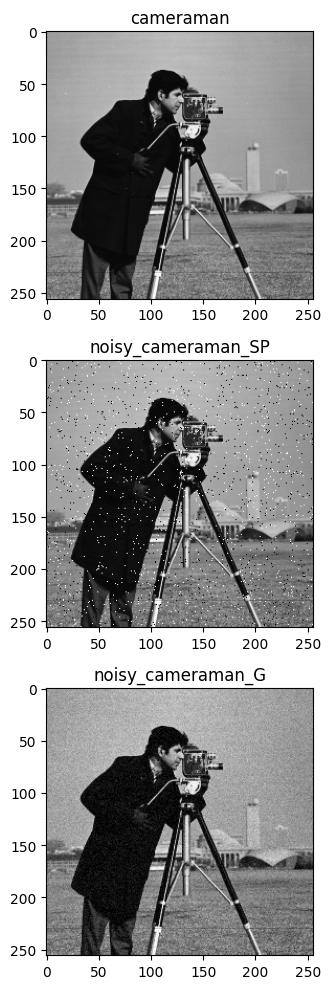

In [3]:
# Chargement et affichage des images du TP
cameraman = cv2.imread(path_images+'cameraman.tif', -1)
noisy_cameraman_SP = cv2.imread(path_images+'noisy_cameraman_SP.tif',-1)
noisy_cameraman_G = cv2.imread(path_images+'noisy_cameraman_G.tif',-1)

fig, axes = plt.subplots(3,1, figsize=(10,10))

axes[0].imshow(cameraman, 'gray', vmin=0, vmax=255)
axes[0].set_title('cameraman')

axes[1].imshow(noisy_cameraman_SP, 'gray', vmin=0, vmax=255)
axes[1].set_title('noisy_cameraman_SP')

axes[2].imshow(noisy_cameraman_G, 'gray', vmin=0, vmax=255)
axes[2].set_title('noisy_cameraman_G')

plt.tight_layout()

plt.show()

**_QUESTION :_** Quelle(s) différences constatez-vous entre l'image originale *cameraman* et les deux images bruitées ? Quels bruitages ont été utilisés ?

*Note :* comparez les images d'abord visuellement, mais ensuite numériquement, notamment en soustrayant une image bruitée à l'image originale, ou en effectuant d'autres manipulations.

Valeur sur l'image bruitée SP des pixels modifiés : [  0 255]


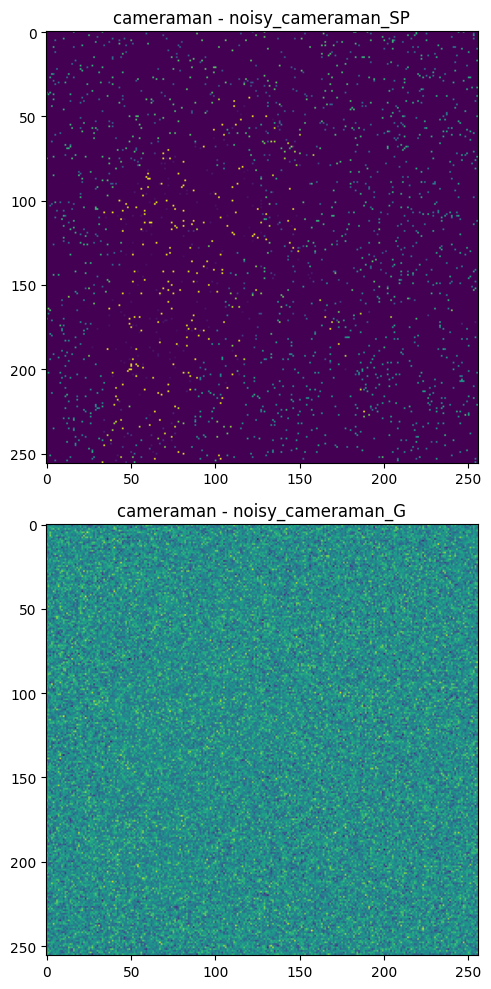

Moyenne de la différence entre G et originale -0.45440673828125
STD de la différence entre G et originale 9.865001990474404


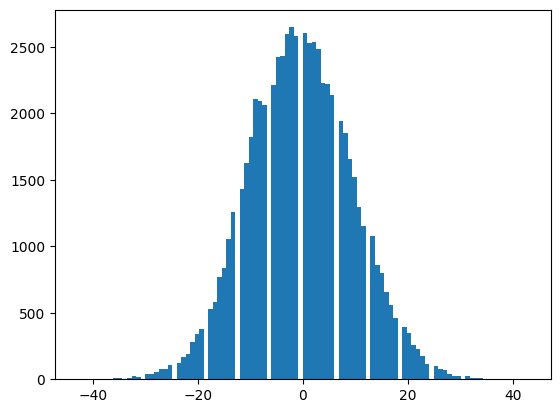

In [5]:
# Comparaison numérique des images
# conversion en floatp pour éviter les dépassements 
# abs(A-B) = abs(B-A) donc on compare les images dans le sens qu'on veut
# mais: img_orig - image_bruitee indique les zones ou le bruit a ajouté
# de l'intensité => image bruitée plus claire
# et: img_bruitee - img_orig indique les zones ou le bruit a diminué
# l'intensité => image bruitée plus sombre
diff_orig_SP = np.abs(noisy_cameraman_SP.astype(float) - cameraman.astype(float))
# Il semble y avoir beaucoup de pixels non changés (différence à zéro)

# on récupère les valeurs des pixels modifiés sur la nouvelle image
print(f"Valeur sur l'image bruitée SP des pixels modifiés : {np.unique(noisy_cameraman_SP[diff_orig_SP!=0])}")

# On remarque que les seules valeurs des pixels modifiées par le bruit 
# sont 0 et 255 => Bruit Poivre et Sel

diff_orig_G = noisy_cameraman_G.astype(float) - cameraman.astype(float)
# on voit que tous les pixels ont été modifiés pour ce cas là.
# on va analyser la matrice de différence: moyenne et écart-type

fig, axes = plt.subplots(2,1, figsize=(10,10))

axes[0].imshow(diff_orig_SP)
axes[0].set_title('cameraman - noisy_cameraman_SP')

axes[1].imshow(diff_orig_G)
axes[1].set_title('cameraman - noisy_cameraman_G')

plt.tight_layout()

plt.show()

print(f"Moyenne de la différence entre G et originale {diff_orig_G.mean()}")
print(f"STD de la différence entre G et originale {diff_orig_G.std()}")

plt.hist(diff_orig_G.ravel(), bins=100)
plt.show()

On a vraisemblablement un bruit gaussien au vu de la forme de l'histogramme et des valeurs de la moyenne et de l'écart-type.

**_REPONSE :_**  
- Sur l'image *noisy_cameraman_SP*, on remarque que seuls une partie des pixels sont bruités, les autres restants similaires que sur l'image originale. Le bruit appliqué montre des pixels blancs (255) ou noirs (0). De ce fait, on remarque que l'image a été bruitée par une fonction de bruit poivre et sel.

- Sur l'image *noisy_cameraman_G*, on remarque que tous les pixels de l'image ont été bruités légèrement (même si on le voit mieux sur les teintes claires). Si on regarde les deux images de loin, on constate quasi aucune différence, avec les mêmes teintes de niveaux de gris. C'est en zoomant qu'on constate le bruit, avec des teintes plus sombres ou plus clairs. De ce fait, l'image a été bruitée par une fonction de bruit gaussien, avec une moyenne à 0 pour garder la teinte de l'image originale.



## Ex. 1 : Et si on filtrait ses vilains bruits ?

Maintenant que nous avons des images bruitées, nous allons les filtrer maintenant ;) Nous allons donc développer plusieurs algorithmes de filtrage vus en cours :D

Commençons d'abord par le filtre le plus connu : le filtre moyenneur. Le principe est simple : la valeur filtrée d'un pixel est celle de la moyenne de lui-même et de son entourage, dans une fenêtre de taille $n \times n$ centrée sur lui-même. Le filtre va donc parcourir tous les pixels de l'image originale, sélectionnez les pixels de l'entourage et calculez la moyenne de ces pixels.

*Ici, on va partir du principe que notre fenêtre est carrée, mais on pourrait faire des fenêtres rectangulaires, en fonction du contexte.*

**Le filtre moyenneur (ou filtre de moyenne glissante) remplace la valeur d'un pixel par la moyenne des intensités des pixels situées dans son voisinage. Ce voisinage est défini par une fenêtre carrée de taille n\*n, centrée sur le pixel.**

Développez la fonction de filtre moyenneur avec en argument l'image à traiter et la taille de fenêtre $n$.

In [18]:
# Développement de la fonction de filtrage moyenneur

# version minimale
def mean_filter(img,n):
    rows, cols = img.shape
    new_img = np.empty((rows,cols), dtype=np.uint8)
    for i in range(rows):
        for j in range(cols):
            # i: lignes => axe vertical (haut/bas)
            # j: colonnes => axe horizontal (gauche/droite)
            fenetre = img[max(i-n//2,0):min(i+n//2+1,rows),
                          max(0, j-n//2):min(1+j+n//2,cols)
            ]
            new_img[i,j] = np.mean(fenetre)
    return new_img

# version optimisée
def mean_filter_fast(img,n):
    # L'astuce est de transformer notre image de taille H x W 
    # en matrice de taille H x W x n²
    # On va concaténer dans un nouvel axe l'image originale,
    # ainsi que plusieurs versions de l'image décaléées en hauteur et largeur. 
    # On aura alors à une même position (i,j) un vecteur représentant 
    # l'entourage du pixel (i,j) sur l'image originale. 
    # Il suffira alors de calculer la moyenne de ce vecteur

    h,w = img.shape

    # Tout d'abord, on va pad notre image, afin d'avoir n-1 lignes et colonnes 
    # supplémentaires, avec l'image originale au centre. 
    # Les valeurs paddées setront des Nan (Not a Number) qui seront ignorées
    # durant le calcul de la moyenne
    padded_img = np.pad(img,((n//2,n//2),(n//2,n//2)))

    # On effectue ensuite les décalages de toutes les images avec 
    # la fonction roll de NumPy. 
    # Grace au padding effectué précédemment, tous les bords de l'image
    # décalée feront apparaître des NaN 
    shifted_images = [np.roll(padded_img,(i-n//2,j-n//2),axis=(0,1)) for i,j in itertools.product(range(n),range(n))]

    # On va concaténer toutes les image sur un nouvel axe.
    # On précise axis=-1 afin d'avoir la nouvelle dimension à la fin.
    # On sélectionne aussi uniquement la zone centrale sans padding.
    stacked_images = np.stack(shifted_images,axis=-1)[n//2:h+n//2,n//2:w+n//2]

    # On calcule la moyenne sur le dernier axe, en utilise nanmean 
    # afin d'éviter que les NaN soient pris en compte dans la moyenne
    return np.nanmean(stacked_images,axis=-1)

Affichez le résultat de l'application du filtre moyenneur sur vos images bruitées. A vous de tester plusieurs valeurs de fenêtres, et de choisir celle qui vous semble la plus pertinente.

*Note : Je n'ai pas besoin que vous me montriez dans le CR toutes les options de tailles de fenêtres testées, montrez-moi juste celle qui pour vous est la plus pertinente.*

Temps d'exécution de Filtrage moyenneur taille n=5 (version minimale) : 2.92 sec
Temps d'exécution de Filtrage moyenneur taille n=5 (version optimisée) : 0.02 sec


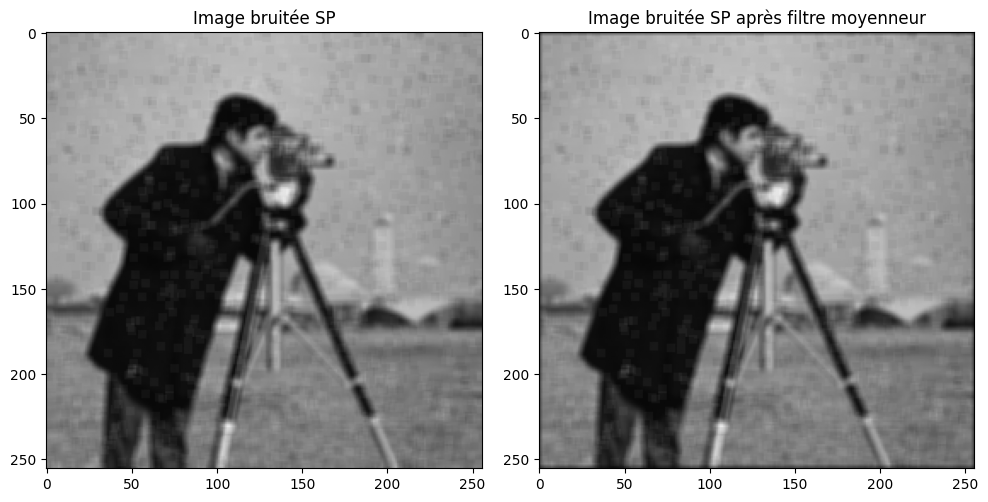

In [19]:
# Filtrage moyenneur sur l'image bruitée SP
n=5
mean_image_SP = chronometrer(mean_filter,"Filtrage moyenneur taille n={} (version minimale)".format(n),noisy_cameraman_SP,n)
mean_image_SP_faster = chronometrer(mean_filter_fast,"Filtrage moyenneur taille n={} (version optimisée)".format(n),noisy_cameraman_SP,n)

# Affichage de l'image sortante
plt.subplots(1,2,figsize=(10,10))

plt.subplot(121)
plt.imshow(mean_image_SP,'gray',vmin=0,vmax=255)
plt.title("Image bruitée SP")

plt.subplot(122)
plt.imshow(mean_image_SP_faster,'gray',vmin=0,vmax=255)
plt.title("Image bruitée SP après filtre moyenneur")

plt.tight_layout()

plt.show()

Temps d'exécution de Filtrage moyenneur taille n=3 (version minimale) : 2.90 sec
Temps d'exécution de Filtrage moyenneur taille n=3 (version optimisée) : 0.01 sec


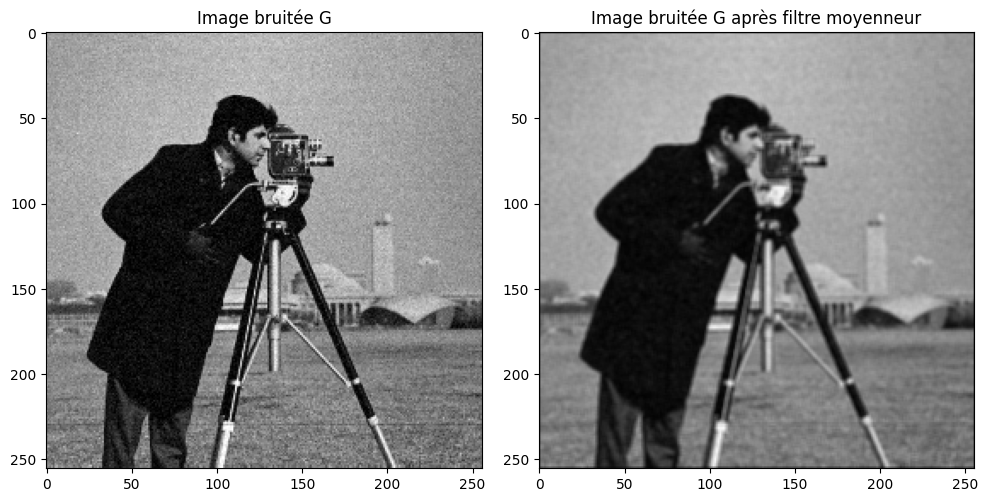

In [20]:
n=3
mean_image_G = chronometrer(mean_filter,"Filtrage moyenneur taille n={} (version minimale)".format(n),noisy_cameraman_G,n)
mean_image_G_faster = chronometrer(mean_filter_fast,"Filtrage moyenneur taille n={} (version optimisée)".format(n),noisy_cameraman_G,n)

# Affichage de l'image sortante
plt.subplots(1,2,figsize=(10,10))

plt.subplot(121)
plt.imshow(noisy_cameraman_G,'gray',vmin=0,vmax=255)
plt.title("Image bruitée G")

plt.subplot(122)
plt.imshow(mean_image_G_faster,'gray',vmin=0,vmax=255)
plt.title("Image bruitée G après filtre moyenneur")

plt.tight_layout()

plt.show()

**_QUESTION :_** Que constatez-vous après application du filtre moyenneur ? Est-ce que le bruit est atténué ? Est-ce que la qualité de l'image est meilleure ?

**_REPONSE :_**
- Sur le bruit S&P, le filtre moyenneur est peu efficace. Il faudrait une fenêtre plus grande, mais alors la qualité de l'image serait fortement dégradée (flou). Cela est dû notamment aux pixels bruités qui influencent trop fortement dans le calcul de la moyenne (extremums forts et faibles).
- Sur le bruit gaussien, le filtre moyenneur s'en sort mieux. La dispersion est plus attenuée, donc on voit moins le bruit. Cependant, l'image devient inévitablement plus floue. Cela n'est pas un problème pour le fond de l'image, mais les détails sur le premier plan sont moins nets.

---

Implémentez maintenant une fonction de filtrage médian de taille *_nxn_* avec *n* impair.

In [31]:
# Développement de la fonction de filtrage médian

# version minimale
def median_filter(img,n):
    rows, cols = img.shape
    new_img = np.empty((rows,cols), dtype=np.uint8)
    # i: lignes => axe vertical (haut/bas)
    # j: colonnes => axe horizontal (gauche/droite)
    for i in range(rows):
        for j in range(cols):
            fenetre = img[max(i-n//2,0):min(1+i+n//2,rows),
                          max(0, j-n//2):min(1+j+n//2,cols)
            ]
            new_img[i,j] = np.median(fenetre)
    return new_img

# version optimisée
def median_filter_fast(img,n):
    # Egalement le même principe que pour mean_filter_faster
    # mais on change la fonction nanmean par nanmedian
    h,w = img.shape
    padded_img = np.pad(img,((n//2,n//2),(n//2,n//2)))
    shifted_images = [np.roll(padded_img,(i-n//2,j-n//2),axis=(0,1)) for i,j in itertools.product(range(n),range(n))]
    stacked_images = np.stack(shifted_images,axis=-1)[n//2:h+n//2,n//2:w+n//2]
    return np.nanmedian(stacked_images,axis=-1)

Vous connaissez déjà la chanson : Affichez le résultat de l'application du filtre médian sur vos images bruitées, en choisissant la taille de fenêtre la plus adaptée à votre image à traiter.

Temps d'exécution de Filtrage moyenneur taille n=3 (version minimale) : 1.50 sec
Temps d'exécution de Filtrage moyenneur taille n=3 (version optimisée) : 0.03 sec


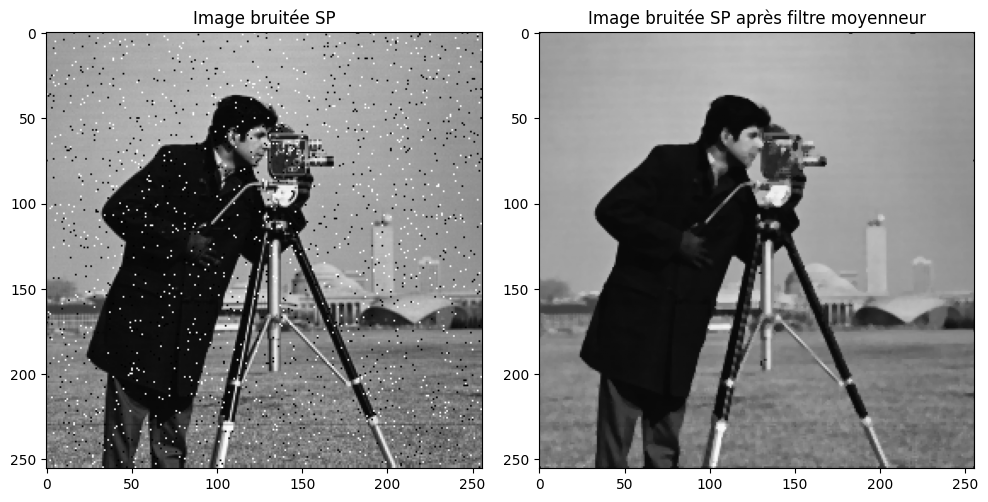

In [34]:
# Filtrage moyenneur sur l'image bruitée SP
n=3
mean_image_SP = chronometrer(median_filter,"Filtrage moyenneur taille n={} (version minimale)".format(n),noisy_cameraman_SP,n)
mean_image_SP_faster = chronometrer(median_filter_fast,"Filtrage moyenneur taille n={} (version optimisée)".format(n),noisy_cameraman_SP,n)

# Affichage de l'image sortante
plt.subplots(1,2,figsize=(10,10))

plt.subplot(121)
plt.imshow(noisy_cameraman_SP,'gray',vmin=0,vmax=255)
plt.title("Image bruitée SP")

plt.subplot(122)
plt.imshow(mean_image_SP_faster,'gray',vmin=0,vmax=255)
plt.title("Image bruitée SP après filtre moyenneur")

plt.tight_layout()

plt.show()

Temps d'exécution de Filtrage moyenneur taille n=5 (version minimale) : 1.63 sec
Temps d'exécution de Filtrage moyenneur taille n=5 (version optimisée) : 0.08 sec


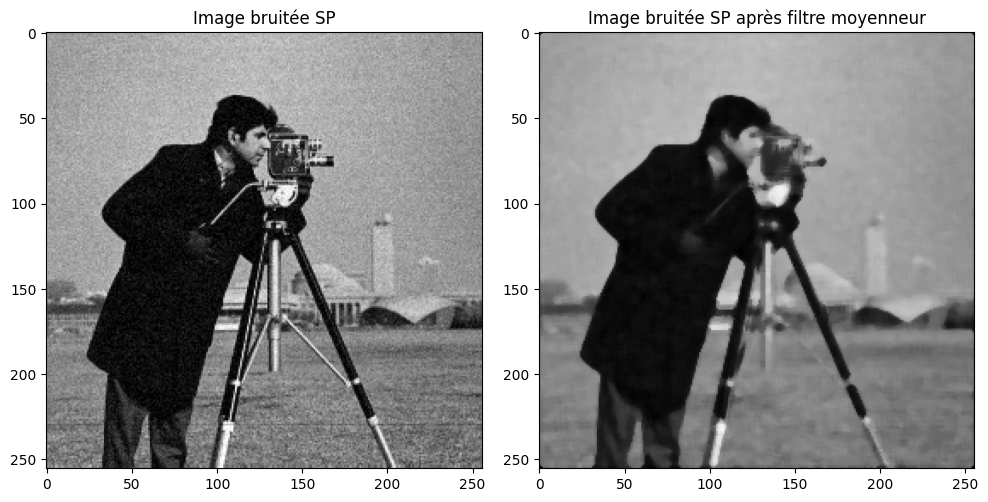

In [39]:
# Filtrage moyenneur sur l'image bruitée SP
n=5
mean_image_SP = chronometrer(median_filter,"Filtrage moyenneur taille n={} (version minimale)".format(n),noisy_cameraman_G,n)
mean_image_SP_faster = chronometrer(median_filter_fast,"Filtrage moyenneur taille n={} (version optimisée)".format(n),noisy_cameraman_G,n)

# Affichage de l'image sortante
plt.subplots(1,2,figsize=(10,10))

plt.subplot(121)
plt.imshow(noisy_cameraman_G,'gray',vmin=0,vmax=255)
plt.title("Image bruitée SP")

plt.subplot(122)
plt.imshow(mean_image_SP_faster,'gray',vmin=0,vmax=255)
plt.title("Image bruitée SP après filtre moyenneur")

plt.tight_layout()

plt.show()

**_QUESTION :_** Que constatez-vous après application du filtre médian ? Est-ce que le bruit est atténué ? Est-ce que la qualité de l'image est meilleure ?

**_REPONSE :_**
- Sur le bruit S&P, le filtre médian est très efficace, avec une petite fenêtre. Les pixels bruités étant blancs ou noirs, ils sont facilement relegué dans le calcul de la valeur médiane. De ce fait, on note plus aucun bruit. L'image est cependant un peu moins nette, mais on ne peut pas faire des miracles non plus...
- Sur le bruit gaussien, le filtre médian atténue un peu le bruit, mais reste moins efficace. Il faut utiliser une plus grosse fenêtre (5, 7) pour réussir à enlever une grosse partie du bruit, mais ça dégrade alors très fortement l'image, en supprimant tous les petits détails (notamment le visage du cameraman)

---

## Ex 2. : La convolution, une seule méthode, une infinité de possibilités !

L'inconvénient de développer les filtres un par un, comme nous étions en train de faire, c'est qu'il faut une méthode par filtre. Et la redondance de code, c'est pas fou. De plus, le principe est assez similaire : une fenêtre glissante qui parcourt l'image, on sélectionne les pixels et on calcule notre image filtrée avec une fonction prédéfinie. C'est pour cela, que nous allons maintenant passer à la convolution 2D. Le principe consiste à définir d'abord un masque de convolution, de la taille de notre fenêtre glissante. Ensuite, on parcourt l'image à traiter en sélectionnant pour chaque pixel son entourage, et on effectue une combinaison linéaire entre la fenêtre de l'image centrée sur le pixel à traiter et notre masque de convolution. De ce fait, on peut faire un grand nombre de filtre juste en définissant le masque. 

Pour une image $A$, avec le masque $h$, le résultat sortant est : 
\begin{equation*}
    C[i,j] = \sum_{k \in W} \sum_{l \in W} h[k,l]A[i-k,j-l]
\end{equation*}
Un pixel *_A[i,j]_* est remplacé par une somme pondérée de lui-même et des pixels de son voisinage *_W_*.

*Note : Il est intéressant de remarquer que ce qu'on appelle ici convolution ici, est en réalité... une corrélation (cf vos supers cours de TDS). C'est un abus de langage, mais pas vraiment car la plupart du temps, on utilise des kernels symétriques, ce qui fait que la corrélation est égal à la convolution.*

La convolution sert à modifier l’image de manière locale selon un noyau, pour filtrer, détecter des motifs, ou accentuer certains détails.

**_QUESTION :_** Est-ce que nos deux précédents filtres peuvent être réaliser par convolution ? Et si oui, quel masque de convolution faut-il définir ?  

**_REPONSE :_** 
- Le filtre moyenneur peut être fait par convolution. Pour un filtre moyenneur de taille $n \times n$, le masque de convolution est le suivant :

\begin{equation*}
    h = 
    \begin{vmatrix}
        1/n & \cdots & 1/n \\
        \vdots & \ddots & \vdots \\
        1/n & \cdots & 1/n
    \end{vmatrix}
\end{equation*}

- Le filtre médian ne peut en revanche être fait par convolution, puisque le calcul réalisé n'est pas une combinaison linéaire, mais issue d'un tri de tableau 1D.

En ce qui concerne le filtre gaussien, le masque de convolution prendra la forme qui suit :

\begin{equation*}
    h(x,y) = \frac{1}{2 \pi \sigma^{2}} exp(-\frac{(x^{2}+y^{2})}{2 \sigma^{2}})
\end{equation*}

Au lieu de faire une fonction générale avec le paramètre $\sigma$ en entrée, nous allons définir les masques nous-même, qui sont un arrondi de la formule. Par exemple, le masque suivant est une approximation avec $\sigma = 0.8$ pour un masque de taille $3x3$.
\begin{equation*}
    h = \frac{1}{16} 
        \begin{vmatrix}
        1 & 2 & 1 \\
        2 & 4 & 2 \\
        1 & 2 & 1
        \end{vmatrix}
\end{equation*}

Créez ce masque dans un premier temps.

In [40]:
# Création du masque de convolution pour un filtrage gaussien
gauss_h = np.array([[1,2,1],[2,4,2],[1,2,1]], dtype=np.float64)/16

Développez maintenant la fonction de convolution, prenant en entrée l'image à traiter et le masque de convolution $h$

padding: ajouter des "bords" autour de l'image afin de pouvoir appliquer le noyau même sur les pixels du bord de l'image (on ajoute artificiellement de 0 tout autour de l'image).

In [42]:
# Implémentation de la fonction de convolution

# version minimale
# h: noyau/filtre
def convolution(img,h):
    # taille du noyau h
    h_rows, h_cols = h.shape
    # taille de l'image
    rows, cols = img.shape
    # création d'une grande image remplie de 0
    # on place img au centre pour le padding.
    large_img = np.zeros((rows+h_rows-1, cols+h_cols-1), dtype=np.uint8)
    large_img[h_rows//2:h_rows//2+rows, h_cols//2:h_cols//2+cols] = img
    out_img = np.zeros((rows,cols),dtype=np.uint8)
    for i in range(rows):
        for j in range(cols):
            # large_img[i:i+h_rows,j:j+h_cols]*h: on prend une 
            # sous-matrice de large_img (celle avec padding) de taille
            # identique au noyau h
            # multiplication par le noyau
            # puis on fait bien la somme des élements pour obtenir 
            # une valeur qui représente le nouveau pixel (i,j)
            # après application du filtre
            out_img[i,j]=np.sum(large_img[i:i+h_rows,j:j+h_cols]*h)
    return out_img

Affichez le résultat de l'application de la convolution avec le kernel gaussien sur l'image bruitée gaussien.

Temps d'exécution de Filtrage gaussien (version minimale) : 0.44 sec
Temps d'exécution de Filtrage gaussien (version optimisée) : 0.39 sec


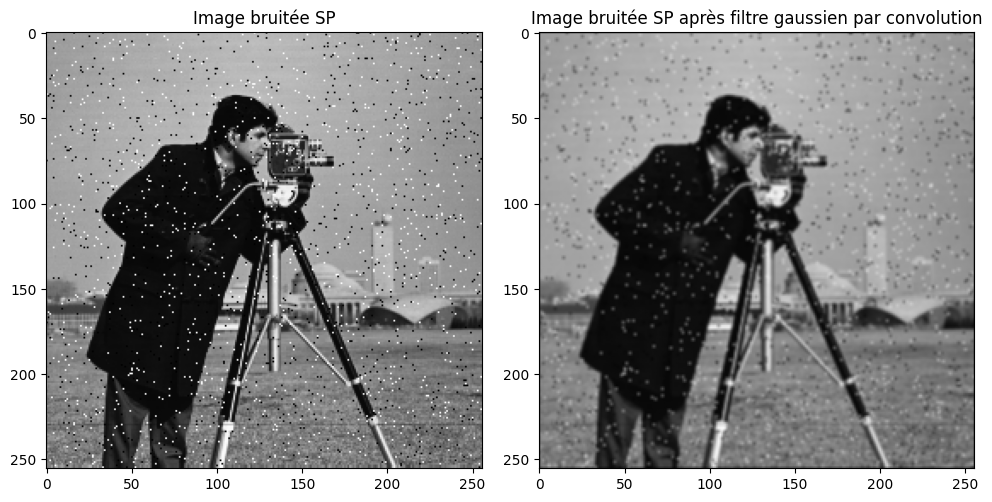

In [49]:
# Filtrage gaussien sur l'image bruitée SP
gauss_image_SP = chronometrer(convolution,"Filtrage gaussien (version minimale)",noisy_cameraman_SP, gauss_h)
gauss_image_SP_faster = chronometrer(convolution,"Filtrage gaussien (version optimisée)",noisy_cameraman_SP, gauss_h)

# Affichage de l'image sortante
plt.subplots(1,2,figsize=(10,10))

plt.subplot(121)
plt.imshow(noisy_cameraman_SP,'gray',vmin=0,vmax=255)
plt.title("Image bruitée SP")

plt.subplot(122)
plt.imshow(gauss_image_SP_faster,'gray',vmin=0,vmax=255)
plt.title("Image bruitée SP après filtre gaussien par convolution")

plt.tight_layout()

plt.show()

Temps d'exécution de Filtrage gaussien (version minimale) : 0.46 sec
Temps d'exécution de Filtrage gaussien (version optimisée) : 0.40 sec


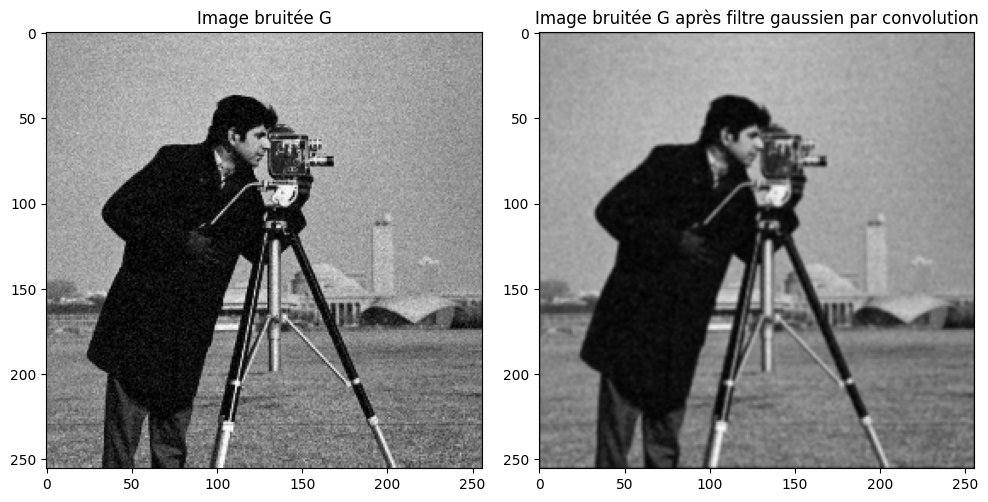

In [52]:
# Filtrage gaussien sur l'image bruitée SP
gauss_image_G = chronometrer(convolution,"Filtrage gaussien (version minimale)",noisy_cameraman_G, gauss_h)
gauss_image_G_faster = chronometrer(convolution,"Filtrage gaussien (version optimisée)",noisy_cameraman_G, gauss_h)

# Affichage de l'image sortante
plt.subplots(1,2,figsize=(10,10))

plt.subplot(121)
plt.imshow(noisy_cameraman_G,'gray',vmin=0,vmax=255)
plt.title("Image bruitée G")

plt.subplot(122)
plt.imshow(gauss_image_G_faster,'gray',vmin=0,vmax=255)
plt.title("Image bruitée G après filtre gaussien par convolution")

plt.tight_layout()

plt.show()

**_QUESTION :_** Que constatez-vous après application du filtre gaussien ? Est-ce que le bruit est atténué ? Est-ce que la qualité de l'image est meilleure ?

**_REPONSE :_**  
Le filtre gaussien ressemble au filtre moyenneur, avec un poids plus important pour le pixel central que pour les pixels alentours. De ce fait, les conclusions de ce filtre sur les images bruitées sont similaires avec ce qui a été constaté pour le filtre moyenneur :
- Pour le bruit SP, le résultat n'est pas très concluant: le bruit est encore très présent, et on note déjà une dégradation de l'image.
- Pour le bruit gaussien, on note une bonne correction, pas parfaite, mais déjà pertinente. Comme noté précédemment, l'image est cependant plus floue.

---

Allez, plus qu'un dernier filtre à développer ! Et ça va être très rapide ;)

En effet, place au filtre exponentiel. Même principe que tout à l'heure, avec une convolution avec un masque de ce type :
\begin{equation*}
    h(x,y) = \frac{\gamma^{2}}{4}exp(-\gamma(|x|+|y|))
\end{equation*}

Pour ce dernier filtre, créez le masque suivant :
\begin{equation*}
    h = \frac{1}{80} 
        \begin{vmatrix}
        1 & 1 & 3 & 1 & 1 \\
        1 & 3 & 7 & 3 & 1 \\
        3 & 7 & 16 & 7 & 3 \\
        1 & 3 & 7 & 3 & 1 \\
        1 & 1 & 3 & 1 & 1 \\
        \end{vmatrix}
\end{equation*}

In [53]:
# Création du masque de convolution pour le filtrage exponentiel
expo_h = np.array([[1,1,3,1,1],
                  [1,3,7,3,1],
                  [3,7,16,7,3],
                  [1,3,7,3,1],
                  [1,1,3,1,1]],dtype=np.float64)/80

Affichez le résultat de l'application de la convolution avec le kernel exponentiel sur l'image bruitée gaussien.

Temps d'exécution de Filtrage gaussien (version minimale) : 0.45 sec
Temps d'exécution de Filtrage gaussien (version optimisée) : 0.44 sec


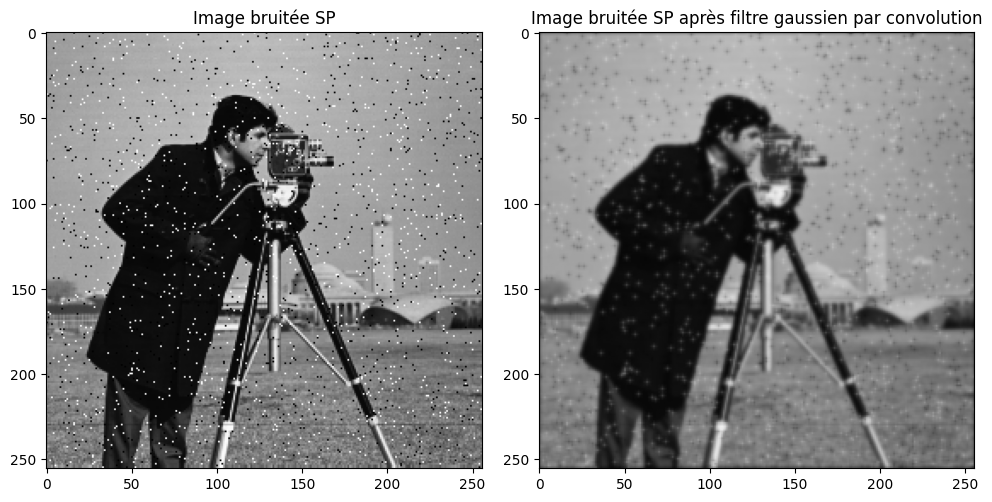

In [54]:
# Filtrage gaussien sur l'image bruitée SP
gauss_image_SP = chronometrer(convolution,"Filtrage gaussien (version minimale)",noisy_cameraman_SP, expo_h)
gauss_image_SP_faster = chronometrer(convolution,"Filtrage gaussien (version optimisée)",noisy_cameraman_SP, expo_h)

# Affichage de l'image sortante
plt.subplots(1,2,figsize=(10,10))

plt.subplot(121)
plt.imshow(noisy_cameraman_SP,'gray',vmin=0,vmax=255)
plt.title("Image bruitée SP")

plt.subplot(122)
plt.imshow(gauss_image_SP_faster,'gray',vmin=0,vmax=255)
plt.title("Image bruitée SP après filtre gaussien par convolution")

plt.tight_layout()

plt.show()

Temps d'exécution de Filtrage gaussien (version minimale) : 0.44 sec
Temps d'exécution de Filtrage gaussien (version optimisée) : 0.41 sec


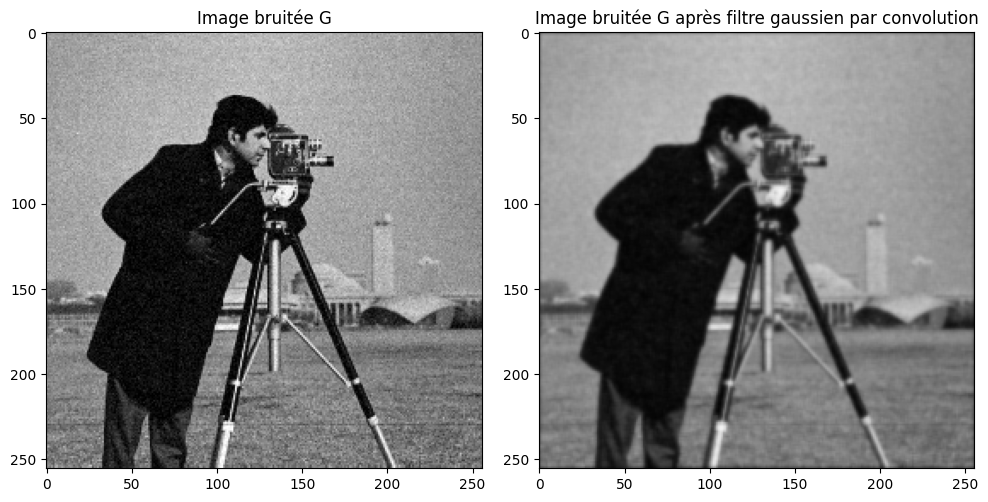

In [57]:
# Filtrage gaussien sur l'image bruitée SP
exp_img_G = chronometrer(convolution,"Filtrage gaussien (version minimale)",noisy_cameraman_G, expo_h)
exp_img_G_faster = chronometrer(convolution,"Filtrage gaussien (version optimisée)",noisy_cameraman_G, expo_h)

# Affichage de l'image sortante
plt.subplots(1,2,figsize=(10,10))

plt.subplot(121)
plt.imshow(noisy_cameraman_G,'gray',vmin=0,vmax=255)
plt.title("Image bruitée G")

plt.subplot(122)
plt.imshow(exp_img_G_faster,'gray',vmin=0,vmax=255)
plt.title("Image bruitée G après filtre gaussien par convolution")

plt.tight_layout()

plt.show()

**_QUESTION :_** Que constatez-vous après application du filtre exponentiel ? Est-ce que le bruit est atténué ? Est-ce que la qualité de l'image est meilleure ?

**_REPONSE :_**  
On a un constat similaire aux résultats avec filtre gaussien. Cependant, malgré la taille du filtre ($5 \times 5$), les détails sont moins affectés dûes à la nature du filtre. 

## Ex 3. : Quoi que je fasse, OpenCV le fait mieux...

On est au 3ème TP, mais on a pas tant utiliser OpenCV que ça, à part pour charger et convertir les images... Il est tant de réparer cela.

On va utiliser la fonction filter2D d'OpenCV. C'est tout simplement la fonction de filtrage par convolution, comme vous l'avez développé. Voilà... C'est tout... 

Bon, du coup, faites un filtre par convolution avec un des kernels déjà constuits et avec la fonction filter2D d'OpenCV. Affichez le résultat, et vérifiez que vous avez le même résultat que précédemment.

Temps d'exécution de Filtrage exponentiel via OpenCV : 0.00 sec


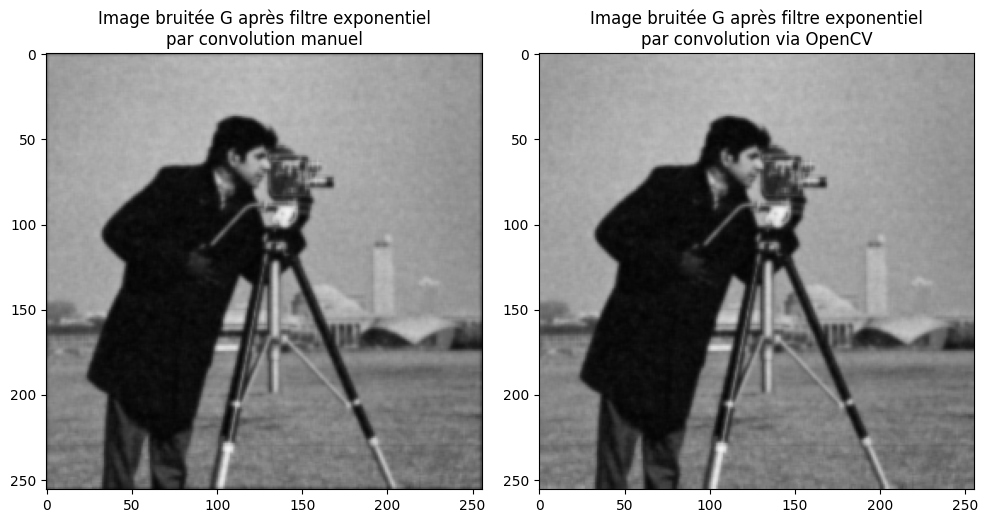

In [59]:
# Filtrage par convolution avec OpenCV
exp_img_G_openCV = chronometrer(cv2.filter2D,"Filtrage exponentiel via OpenCV",noisy_cameraman_G.astype(float),cv2.CV_64F,expo_h).astype(np.uint8)

# Affichage de l'image sortante
plt.subplots(1,2,figsize=(10,10))

plt.subplot(121)
plt.imshow(exp_img_G_faster,'gray',vmin=0,vmax=255)
plt.title("Image bruitée G après filtre exponentiel\npar convolution manuel")

plt.subplot(122)
plt.imshow(exp_img_G_openCV,'gray',vmin=0,vmax=255)
plt.title("Image bruitée G après filtre exponentiel\npar convolution via OpenCV")

plt.tight_layout()

plt.show()

**_QUESTION :_** Est-ce que vous obtenez **exactement** le même résultat ? Quels sont les changements ?

*Note : Faites une comparaison visuelle mais également numérique des deux images résultantes.* 

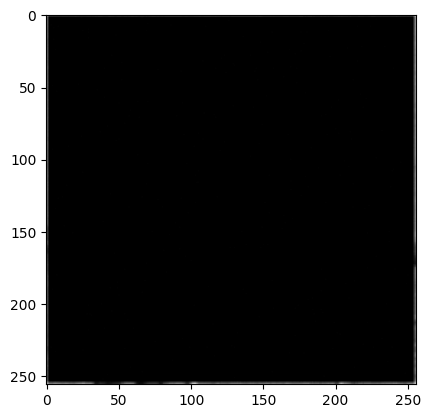

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 58. 60. 61. 73. 75.]


In [61]:
# Comparaison entre les deux images filtrées
diff=np.abs(exp_img_G_faster.astype(float)-exp_image_G_openCV.astype(float))

plt.imshow(diff,'gray')
plt.show()
print(np.unique(diff))

**_REPONSE :_**  
**_REPONSE :_** Déjà, dans un premier temps, l'argument ddepth de filter2D est assez important. En effet, il précise le type de données de retour de votre image. Cependant, avec la même image en entrée, si vous retournez le même type en retour, tous les calculs à l'intérieur de la fonction ne seront jamais convertis. Exemple : si mon image d'entrée est uint8 et le type de sortie est également uint8, alors tous les calculs faits durant la fonction seront en uint8. Cela fait que si j'ai des dépassements (en dessous de 0 ou au-dessus de 255), le résultat sera impacté. De ce fait, **le premier point ultra important, c'est de convertir vos images uint8 en float avant tout filtrage, puis ensuite convertir le résultat en uint8.**

Hormis quelques pixels à l'intérieur de l'image avec une différence de 1, ce qui suggère quelques différences de précisions de calculs exacerbés avec un arrondi pour passer en uint8, la différence principale se fait dans les bords de l'image. Cela peut se paramétrer dans filter2D. A vous de choisir ce que vous considérez comme meilleur, il n'y a pas une meilleure solution qu'une autre.

## Ex 4. : Au secours ! Je suis nul en photo !!

Un dernier exercice pas simple. J'ai pris une photo d'un code-barre mais elle n'est pas terrible. A vous de me venir en aide ! Il faudrait que vous binarisiez l'image afin d'avoir le code barre en noir et le fond en blanc.

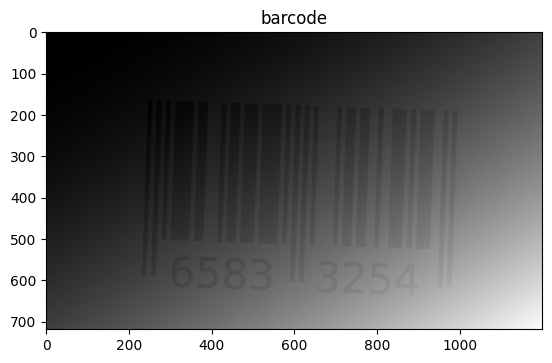

In [65]:
# Chargement de l'image de code barre
barcode = cv2.imread(path_images+'barcode.png', 0)

# Affichage du code barre
plt.imshow(barcode, 'gray', vmin=0, vmax=255)
plt.title('barcode')
plt.show()

Vous pouvez essayer directement de binariser l'image, mais alors bon courage...

Ce qu'on va faire dans un premier temps, c'est analyser l'image, en constatant tous les *problèmes* qu'elle a.

**_ANALYSE :_**

- Le premier constat est évidemment le fond qui n'est pas uniforme. De ce fait, il n'y a pas de seuil de binarisation efficace. On peut essayer de corriger avec nos algorithmes sur les histogrammes, mais ce n'est pas adapté totalement ici
- Si on zoom sur l'image, on constate un léger bruit qui rend le fond et le code barre pas totalement lisse. On suppose un léger bruit gaussien

Après avoir analyser l'image, à vous de définir des corrections possibles pour améliorer l'image

**_CORRECTIONS :_**
- On commence par le **léger bruit gaussien. Pour lisser tout cela, on va effectuer un filtrage moyenneur ou gaussien avec un petit kernel ($3 \times 3$)**
- Le fond uniforme est plus problématique. Ici, on va essayer d'extraire le background de l'image. Pour cela, on va appliquer sur l'image corrigée un filtrage moyenneur avec un gros kernel ($101 \times 101$), avec comme objectif d'éliminer le code barre. On va donc ensuite faire la soustraction de l'image avec le background. Enfin, on va modifier l'histogramme de l'image soustraite, via une normalisation pour placer les valeurs entre 0 et 255.
- En fonction des résultats obtenus, et à l'appréciation visuelle de l'image, on pourra appliquer d'autres traitements avant une binarisation.

On devrait alors pouvoir binariser l'image.

Mettez en place votre proposition de correction d'image, et tentez de binariser ce foutu code barre !

Le background est la partie lisse et uniforme de l’image.
Les barres du code-barres sont des détails fins (changement rapide de pixels noirs → blancs).
Si on utilise un très grand noyau moyenneur (101×101 par exemple) :
- Chaque pixel devient la moyenne de ses 101×101 voisins
- Les petits détails comme les barres noires disparaissent
- On obtient seulement le fond lisse → c’est le background.

1) Filtrage pour atténuer le bruit gaussien de l'image: les pixels sont remplacées par une moyenne pondée de leur voisin. Résultat: image plus "lisse", les petits bruits disparaissent.
2) Extraction du background par l'utilisation d'un filtre moyenneur très large (101\*101) pour lisser l'image => les petits détails (barres noires) disparaissent.
3) Soustraction du background: on enlève le fond pour isoler les détails, cad les barres du code-barre.
4) Normalisation: on ajuste les valeurs pour que chaque pixel soit entre 0 et 255. Cela permet un meilleur contraste et de facilier la binarisation.
5) Lissage pour atténuer les petits défauts restants de la soustraction du background.
6) Egalisaiton d'histogramme: on répartit les niveaux de gris de façon uniforme pour améliorer le contraste (méthode des histogrammes cumulatifs).
7) Binarisation finale: converssion de l'image en noir/blanc avec un seuil fixé ici à 50. Cela donne une image finale nette du code-barre.

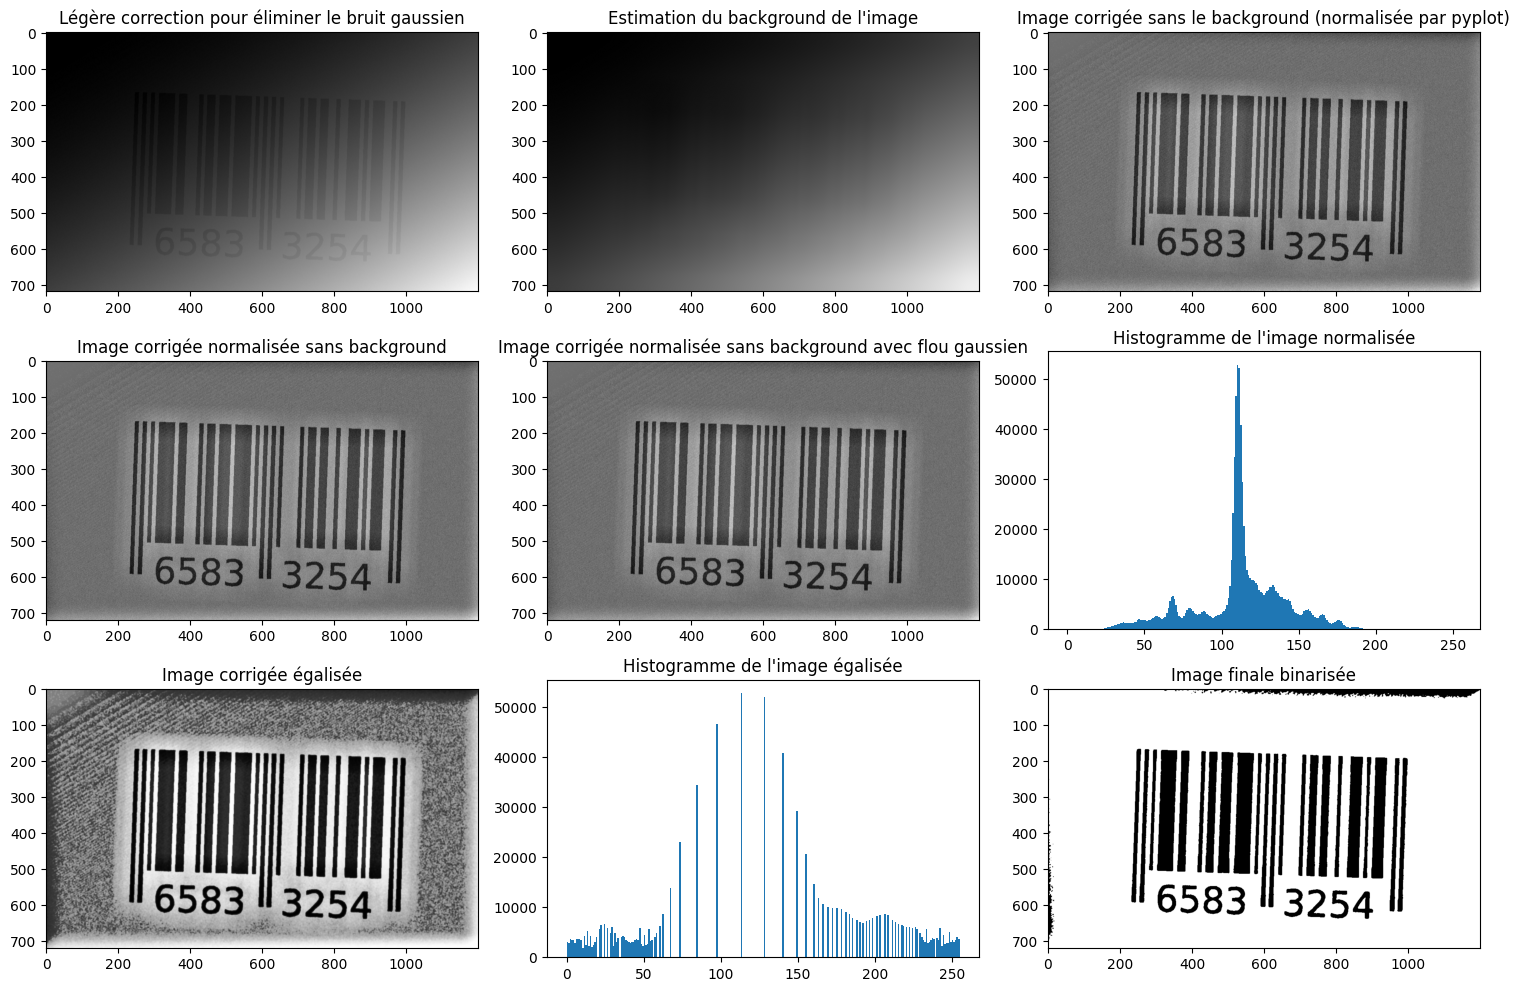

In [75]:
# Correction de l'image du code barre et binarisation
plt.subplots(3,3,figsize=(15,10))

# 1ère étape : filtrage gaussien pour éliminer au mieux un bruit gaussien
gaussian_kernel = cv2.getGaussianKernel(3,0.8)
blurred_image = cv2.filter2D(barcode.astype(float),-1,gaussian_kernel).astype(np.uint8)

plt.subplot(331)
plt.imshow(blurred_image,'gray',vmin=0,vmax=255)
plt.title('Légère correction pour éliminer le bruit gaussien')

# 2ème étape : Extraction du background grâce à un gros filtre moyenneur (avec un gros noyau, de taille 101x101)
# on lisse tout ce qui est petit (les barres) afin de ne garder que le fond
size = 101
# matrice remplie de 1
mean_kernel_background = np.ones((size,size))/(size**2)
background_image = cv2.filter2D(blurred_image.astype(float),-1,mean_kernel_background)

plt.subplot(332)
plt.imshow(background_image,'gray',vmin=0,vmax=255)
plt.title("Estimation du background de l'image")

# 3ème étape : Soustraction du background sur l'image corrigée
substract_image = blurred_image.astype(float)-background_image.astype(float)

plt.subplot(333)
plt.imshow(substract_image,'gray') # Attention, ici, j'affiche volontairement l'image sans préciser vmin et vmax en uint8, car ma range de valeur n'est pas correcte du tout
plt.title("Image corrigée sans le background (normalisée par pyplot)")

# 4ème étape : Normalisation de l'image pour avoir les valeurs situées entre 0 et 255
img_min = substract_image.min()
img_max = substract_image.max()

normalised_image = (((substract_image.astype(float)-img_min)/(img_max-img_min))*255)

plt.subplot(334)
plt.imshow(normalised_image,'gray',vmin=0,vmax=255) 
plt.title("Image corrigée normalisée sans background")

# 5ème étape : Flou gaussien pour éliminer au mieux les rayures après soustraction du background
blurred_normalised_image = cv2.GaussianBlur(normalised_image,(7,7),0).astype(np.uint8)
plt.subplot(335)
plt.imshow(normalised_image,'gray',vmin=0,vmax=255) 
plt.title("Image corrigée normalisée sans background avec flou gaussien")

# Affichage de l'histogramme après normalisation
plt.subplot(336)
plt.hist(blurred_normalised_image.ravel(),bins=range(0,256))
plt.title("Histogramme de l'image normalisée")


# 6ème étape : Egalisation d'histogramme pour mieux répartir les niveaux de gris
def histo_cum(image):
    unique,counts = np.unique(image,return_counts=True)
    output = np.zeros(256)
    output[unique]=counts
    return np.cumsum(output)

def equal_hist_faster(image):
    L = 256
    rows,cols = image.shape
    N = rows*cols
    return np.floor(((L-1)/N)*histo_cum(image)[image]).astype(np.uint8)

egal_image = equal_hist_faster(blurred_normalised_image)

plt.subplot(337)
plt.imshow(egal_image,'gray',vmin=0,vmax=255) 
plt.title("Image corrigée égalisée")

# Affichage de l'histogramme après normalisation
plt.subplot(338)
plt.hist(egal_image.ravel(),bins=range(0,256))
plt.title("Histogramme de l'image égalisée")

# 7ème étape : Binarisation finale
bin_image = ((egal_image>50)*255).astype(np.uint8)
plt.subplot(339)
plt.imshow(bin_image,'gray',vmin=0,vmax=255)
plt.title("Image finale binarisée")
plt.tight_layout()
plt.show()

Analysez le résultat de votre binarisation finale. Est-ce que c'est concluant ?

**_ANALYSE DE LA CORRECTION :_** 

On obtient un code-barre plutôt correct en sortie, sans forte dégradation. On a un peu de bruit au-dessus et à gauche de l'image, mais c'est assez distinguable du code-barre, et on peut donc facilement le supprimer.

Maintenant, la chaîne de traitement utilisée ici est lourde, et peut être vraiment simplifiée, avec d'autres méthodes que vous verrez dans les prochains TP (suspense insoutenable !)